In [1]:
!pip install kagglehub
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kagglehub
import pandas as pd

import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

d:\Code\Data Science\Projects\brazilian-e-commerce-nlp-deep-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_orders_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


## Dataset

In [3]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\darth\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


In [4]:
# Reading all the files
# olist_customer = pd.read_csv(path + 'olist_customers_dataset.csv')
# olist_geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
# olist_orders = pd.read_csv(path + 'olist_orders_dataset.csv')
# olist_order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
# olist_order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(path + '//olist_order_reviews_dataset.csv')
# olist_products = pd.read_csv(path + 'olist_products_dataset.csv')
# olist_sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')

In [5]:
olist_order_reviews.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)

print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


We will consider a binary classification problem, with negative comments being with score below 4 and good reviews being 4 and 5.

In [7]:
y = df_comments['score']
y = y.apply(lambda x: 0 if x < 4 else 1)

len(y)

40977

In [8]:
y.value_counts(sort=False)

score
1    26530
0    14447
Name: count, dtype: int64

We have almost 41k comments that could be used for training a sentimental analysis model. But, beforehand we have to do some preprocessing on the text to transform the comment input into a vector that can be interpreted for a Machine Learning model.

## Natural language processing

### Regular expressions

First lest's define a function to help visualize transformations on data.

In [9]:
def print_diff(dataset_original, dataset_changed, limit=4):
    # Print the original and changed values from lists
    count = 0
    for original, modified in zip(dataset_original, dataset_changed):
        if original != modified:
            print(f'Original: {original}')
            print(f'Changed:  {modified}')
            print('')
            count += 1
            if count >= limit:
                break

##### \n and \r

As long as we consider the global internet as the source of our comments, probably we have to deal with some HTML tags, break lines, special characteres and other content that could be part of the dataset. Let's dig a little bit more on Regular Expressions to search for those patterns.

First of all, let's define a function that will be used for analysing the results of an applied regular expression. With this we can validate our text pre processing in an easier way.

In [10]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_diff(reviews, reviews_breakline)

Original: Mas um pouco ,travando...pelo valor ta Boa.

Changed:  Mas um pouco ,travando...pelo valor ta Boa.  

Original: A compra foi realizada facilmente.
A entrega foi efetuada muito antes do prazo dado.
O produto já começou a ser usado e até o presente,
sem problemas.
Changed:  A compra foi realizada facilmente.  A entrega foi efetuada muito antes do prazo dado.  O produto já começou a ser usado e até o presente,  sem problemas.

Original: recebi somente 1 controle Midea Split ESTILO.
Faltou Controle Remoto para Ar Condicionado Consul
Changed:  recebi somente 1 controle Midea Split ESTILO.  Faltou Controle Remoto para Ar Condicionado Consul

Original: Ocorreu tudo como contratado sendo a entrega realizada antes do prazo 
 Estou satisfeita

Changed:  Ocorreu tudo como contratado sendo a entrega realizada antes do prazo    Estou satisfeita  



##### links

In [11]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Printing differences
print_diff(reviews_breakline, reviews_hiperlinks)

Original: comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/
Changed:  comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 



##### dates

In [12]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]


# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_diff(reviews_hiperlinks, reviews_dates)


Original: A targaryen não é de confiança não entregou a minha compra e colocou no rastreamento do pedido que foi entregue no dia 14/12/17 empresa falsa quero receber meus produtos que foram pagos com boleto bancari
Changed:  A targaryen não é de confiança não entregou a minha compra e colocou no rastreamento do pedido que foi entregue no dia  data  empresa falsa quero receber meus produtos que foram pagos com boleto bancari

Original: ENTREGA MUITO DEMORADA, COMPREI EM 26/03/2018 E ATÉ AGORA NÃO RECEBI OS PRODUTOS
Changed:  ENTREGA MUITO DEMORADA, COMPREI EM  data  E ATÉ AGORA NÃO RECEBI OS PRODUTOS

Original: ainda nao recebi e a ultima informacao sobre p produto e do dia 08/12/2017.
Changed:  ainda nao recebi e a ultima informacao sobre p produto e do dia  data .

Original: Comprei duas bonecas baby kiss Sid nil dia 07/12/17 e eles entregaram somente 1 boneca ,não veio junto nota fiscal,caixa amassada e também não consigo contato com a lannister o telefone só da ocupado
Changed:  Com

##### money

In [13]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """

    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_diff(reviews_dates, reviews_money)

Original: Este foi o pedido  Balde Com 128 Peças - Blocos De Montar 2 un - R$ 25,00 cada (NÃO FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras 36 Peças Crianças 1 un - R$ 35,90 (ESTE FOI ENTREG
Changed:  Este foi o pedido  Balde Com 128 Peças - Blocos De Montar 2 un -  dinheiro  cada (NÃO FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras 36 Peças Crianças 1 un -  dinheiro  (ESTE FOI ENTREG

Original: Comprei 4 produtos, sendo que só recebi 3. Faltou um lençol branco sem elástico. Foi quase R$ 100,00. E como eu fico? No prejuizo?
Changed:  Comprei 4 produtos, sendo que só recebi 3. Faltou um lençol branco sem elástico. Foi quase  dinheiro . E como eu fico? No prejuizo?

Original: Relógio belíssimo, muito elegante, inacreditável diante do valor de menos de R$ 150,00! Veio muito bem embrulhado e protegido, fora que tem também caixa muito chique, como se fosse jóia!!! Recomendo
Changed:  Relógio belíssimo, muito elegante, inacreditável diante do valor

#### numbers

In [14]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

print_diff(reviews_money, reviews_numbers)

Original: aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
Changed:  aparelho eficiente. no site a marca do aparelho esta impresso como  numero desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho

Original: Loja nota 10
Changed:  Loja nota  numero 

Original: recebi somente 1 controle Midea Split ESTILO.  Faltou Controle Remoto para Ar Condicionado Consul
Changed:  recebi somente  numero  controle Midea Split ESTILO.  Faltou Controle Remoto para Ar Condicionado Consul

Original: Este foi o pedido  Balde Com 128 Peças - Blocos De Montar 2 un -  dinheiro  cada (NÃO FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras 36 Peças Crianças 1 un -  dinheiro  (ESTE FOI ENTREG
Changed:  Este foi o pedido  Balde Com  numero  Peças - Blocos De Montar  numero  un -  dinheiro  cada (NÃO FOI ENTREGUE)  Vend

#### negation

In [15]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

print_diff(reviews_numbers, reviews_negation)

Original: Não gostei ! Comprei gato por lebre
Changed:   negação  gostei ! Comprei gato por lebre

Original: Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.
Changed:  Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda  negação  recebi o produto.

Original: O produto não chegou no prazo estipulado e causou transtorno, pq programei a viagem de férias do meu filho, baseado no prazo. Moro na Bahia e ele em Cuiabá sozinho. Agora, a casa está vazia. 
Changed:  O produto  negação  chegou no prazo estipulado e causou transtorno, pq programei a viagem de férias do meu filho, baseado no prazo. Moro na Bahia e ele em Cuiabá sozinho. Agora, a casa está vazia. 

Original: Produto bom, porém o que veio para mim não condiz com a foto do anúncio.
Changed:  Produto bom, porém o q

##### special characters

In [16]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    return [re.sub('\W', ' ', r) for r in text_list]

reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

print_diff(reviews_negation, reviews_special_chars, limit=6)

Original: Recebi bem antes do prazo estipulado.
Changed:  Recebi bem antes do prazo estipulado 

Original: aparelho eficiente. no site a marca do aparelho esta impresso como  numero desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
Changed:  aparelho eficiente  no site a marca do aparelho esta impresso como  numero desinfector e ao chegar esta com outro nome   atualizar com a marca correta uma vez que é o mesmo aparelho

Original: Mas um pouco ,travando...pelo valor ta Boa.  
Changed:  Mas um pouco  travando   pelo valor ta Boa   

Original: Vendedor confiável, produto ok e entrega antes do prazo.
Changed:  Vendedor confiável  produto ok e entrega antes do prazo 

Original: GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU
Changed:  GOSTARIA DE SABER O QUE HOUVE  SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU

Original: A compra foi realizada facilmente.  A entrega foi efetuada muito antes do prazo d

##### whitespaces

In [17]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_diff(reviews_special_chars, reviews_whitespaces)

Original: Recebi bem antes do prazo estipulado 
Changed:  Recebi bem antes do prazo estipulado

Original: aparelho eficiente  no site a marca do aparelho esta impresso como  numero desinfector e ao chegar esta com outro nome   atualizar com a marca correta uma vez que é o mesmo aparelho
Changed:  aparelho eficiente no site a marca do aparelho esta impresso como numero desinfector e ao chegar esta com outro nome atualizar com a marca correta uma vez que é o mesmo aparelho

Original: Mas um pouco  travando   pelo valor ta Boa   
Changed:  Mas um pouco travando pelo valor ta Boa

Original: Vendedor confiável  produto ok e entrega antes do prazo 
Changed:  Vendedor confiável produto ok e entrega antes do prazo



##### stopwords

In [18]:
# Download stopwords
nltk.download('stopwords')

# Examples of some portuguese stopwords
pt_stopwords = nltk.corpus.stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
print(pt_stopwords[:10])

Total portuguese stopwords in the nltk.corpous module: 207
['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=nltk.corpus.stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_diff(reviews_whitespaces, reviews_stopwords)

Original: Recebi bem antes do prazo estipulado
Changed:  recebi bem antes prazo estipulado

Original: Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
Changed:  parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa

Original: aparelho eficiente no site a marca do aparelho esta impresso como numero desinfector e ao chegar esta com outro nome atualizar com a marca correta uma vez que é o mesmo aparelho
Changed:  aparelho eficiente site marca aparelho impresso numero desinfector chegar outro nome atualizar marca correta vez aparelho

Original: Mas um pouco travando pelo valor ta Boa
Changed:  pouco travando valor ta boa



##### stemming

Sure! Stemming is a text normalization process used in Natural Language Processing (NLP) to reduce words to their root or base form. The goal is to group together different forms of a word so they can be analyzed as a single item. For example, the words "running", "runner", and "ran" can all be reduced to the root word "run".

In summary, stemming helps in reducing words to their base form, which can be useful for various NLP tasks such as text classification, sentiment analysis, and information retrieval.

In [20]:
# Download rslp
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\darth\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [21]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=nltk.stem.RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_diff(reviews_stopwords, reviews_stemmer)

Original: recebi bem antes prazo estipulado
Changed:  receb bem ant praz estipul

Original: parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa
Changed:  parabém loj lannist ador compr internet segur prát parabém tod feliz pásco

Original: aparelho eficiente site marca aparelho impresso numero desinfector chegar outro nome atualizar marca correta vez aparelho
Changed:  aparelh efici sit marc aparelh impress numer desinfec cheg outr nom atual marc corret vez aparelh

Original: pouco travando valor ta boa
Changed:  pouc trav val ta boa



In [22]:
reviews_final = reviews_stemmer

# Sentiment Classification

In [23]:
# models = {
#     "Naive Bayes": MultinomialNB(),
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Support Vector Machine": SVC()
# }

# for model_name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"Model: {model_name}")
#     print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
#     print(classification_report(y_test, y_pred))
#     print()

## Deep Neural Networks

In [24]:
import numpy as np
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [25]:
# Tokenização e padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews_final)

reviews_sequences = tokenizer.texts_to_sequences(reviews_final)

max_length = max(len(seq) for seq in reviews_sequences)
reviews_padded = pad_sequences(reviews_sequences, maxlen=max_length, padding='post')

Dive data into train, validation and test (80%, 10%, 10%).

In [26]:
def train_val_test_split(X, y):
    # Initial division: train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Divisão secundária: separa uma parte do treino para validação
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(reviews_padded, y)
print(f"Sizes: \n train: {len(X_train)} \n val: {len(X_val)} \n test: {len(X_test)}")

Sizes: 
 train: 32781 
 val: 4098 
 test: 4098


In [27]:
tf.random.set_seed(42)

In [28]:
dense_model = models.Sequential()

# Input - Layer
dense_model.add(layers.Dense(50, activation = "relu", input_shape=(max_length, )))
# Hidden - Layers
dense_model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
dense_model.add(layers.Dense(50, activation = "relu"))
dense_model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
dense_model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
dense_model.add(layers.Dense(1, activation = "sigmoid"))
dense_model.summary()

d:\Code\Data Science\Projects\brazilian-e-commerce-nlp-deep-learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,051 (27.54 KB)

 Trainable params: 7,051 (27.54 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Definir o callback de early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Métrica a ser monitorada (pode ser 'val_accuracy' ou 'val_loss')
    patience=5,          # Número de épocas sem melhoria para parar o treinamento
    restore_best_weights=True  # Restabelece os melhores pesos do modelo
)

In [30]:
dense_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [31]:
results = dense_model.fit(
    X_train, y_train,
    epochs= 100,
    batch_size = 128,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5538 - loss: 16.0528 - val_accuracy: 0.6730 - val_loss: 2.2637
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6431 - loss: 3.4675 - val_accuracy: 0.6669 - val_loss: 1.4403
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.6592 - loss: 2.0225 - val_accuracy: 0.6691 - val_loss: 0.8061
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6692 - loss: 1.2692 - val_accuracy: 0.6762 - val_loss: 0.9245
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.6736 - loss: 1.0973 - val_accuracy: 0.6679 - val_loss: 0.8163
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.6706 - loss: 0.9706 - val_accuracy: 0.6532 - val_loss: 0.6569
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6676 - loss: 0.8370 - val_accuracy: 0.6752 - val_loss: 0.6917
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6738 - loss: 0.

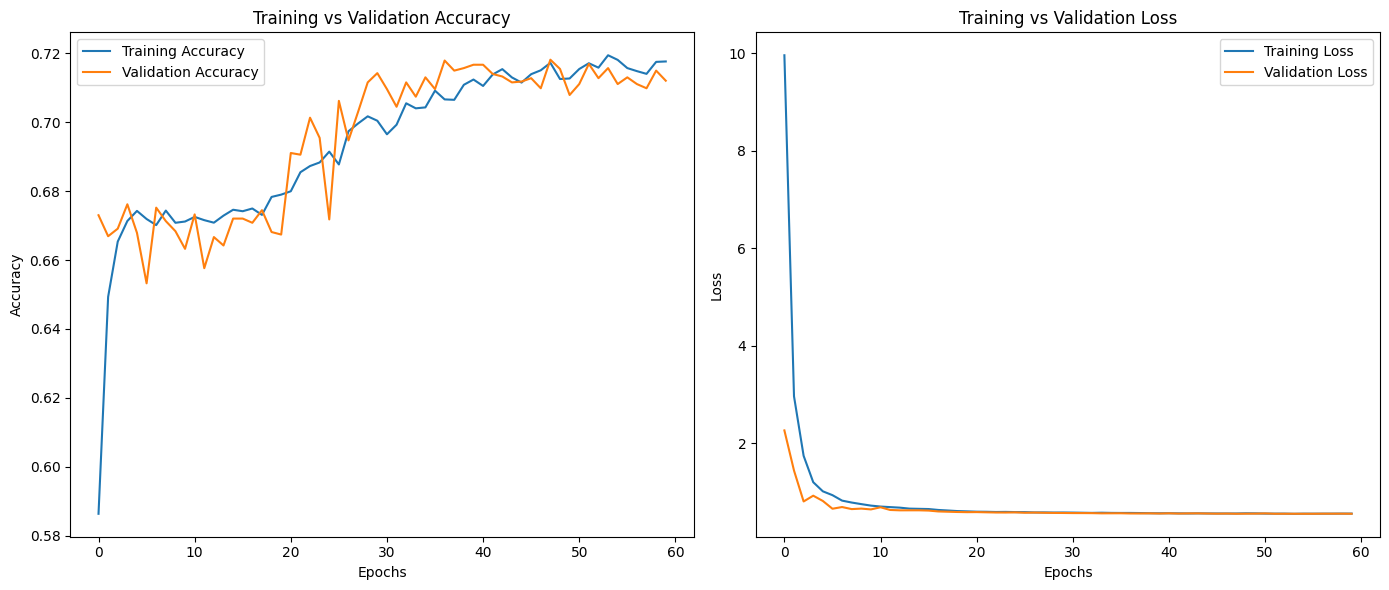

In [32]:
def plot_hist(hist):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot de acurácia
    axs[0].plot(hist.history['accuracy'], label='Training Accuracy')
    axs[0].plot(hist.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training vs Validation Accuracy')
    axs[0].legend()

    # Plot de loss
    axs[1].plot(hist.history['loss'], label='Training Loss')
    axs[1].plot(hist.history['val_loss'], label='Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training vs Validation Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_hist(results)

In [33]:
scores = dense_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 72.50%


### LSTM

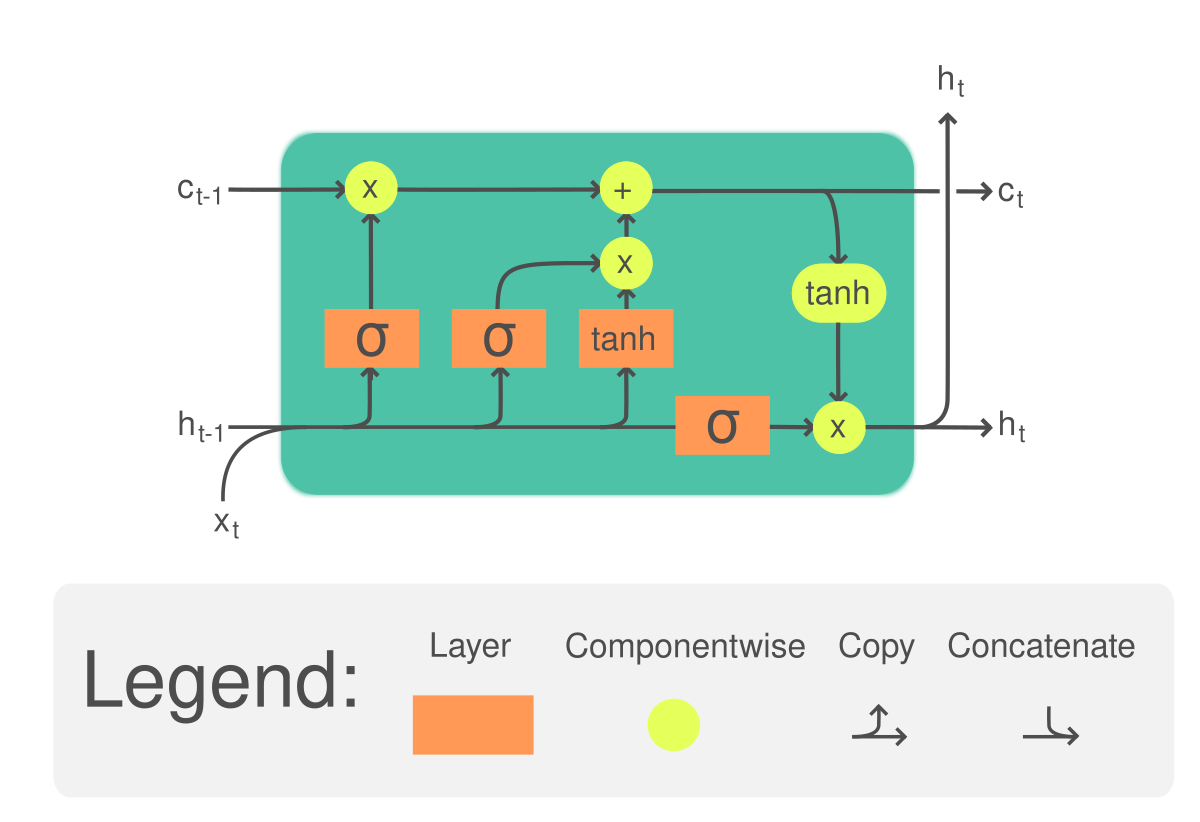

In [34]:
lstm_model = models.Sequential()
lstm_model.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_length))
lstm_model.add(layers.LSTM(units=128, return_sequences=True))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.LSTM(units=128))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.Dense(units=1, activation='sigmoid'))

lstm_model.summary()

d:\Code\Data Science\Projects\brazilian-e-commerce-nlp-deep-learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
lstm_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [36]:
history = lstm_model.fit(
    X_train, y_train,
    epochs= 100,
    batch_size = 32,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8332 - loss: 0.4011 - val_accuracy: 0.8782 - val_loss: 0.3480
Epoch 2/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8984 - loss: 0.2918 - val_accuracy: 0.8812 - val_loss: 0.3247
Epoch 3/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9086 - loss: 0.2701 - val_accuracy: 0.8726 - val_loss: 0.3168
Epoch 4/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9157 - loss: 0.2471 - val_accuracy: 0.8882 - val_loss: 0.2915
Epoch 5/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9263 - loss: 0.2194 - val_accuracy: 0.8873 - val_loss: 0.2984
Epoch 6/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9327 - loss: 0.2033 - val_accuracy: 0.8860 - val_loss: 0.3217
Epoch 7/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9227 - loss: 0.2250 - val_accuracy: 0.8865 - val_loss: 0.3177
Epoch 8/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 

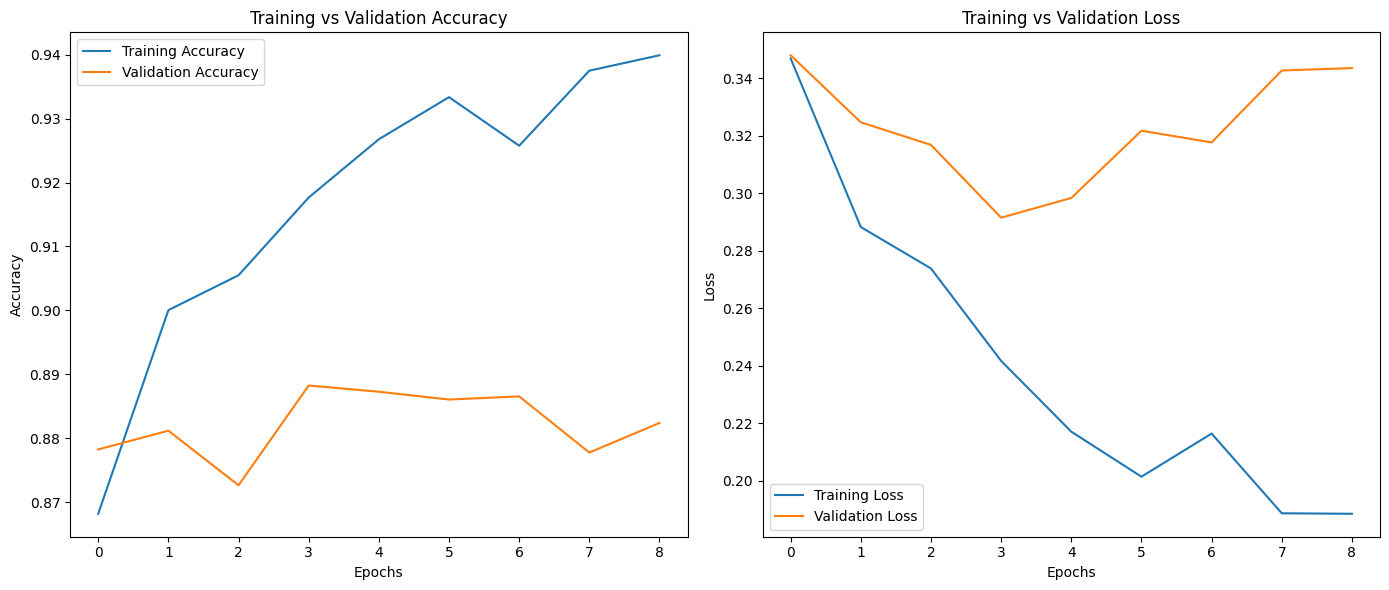

In [37]:
plot_hist(history)

In [38]:
scores = lstm_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.41%


LSTM approach was clearly better, as expected. So we will be using it as a base for our next evaluations.

## KFold Cross validation

We will performe cross validation using K-Fold with different amount of hidden layers and neurons.

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds

param_grid = {
    'num_layers': [1, 2, 3],
    'units_per_layer': [32, 64, 128],
}


In [40]:
def create_lstm_model(num_layers, units_per_layer, input_shape):
    model = models.Sequential()
    
    model.add(layers.Embedding(input_dim=input_shape[0], output_dim=50))
    
    # LSTM layers
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Last layers doesn't return sequence
        model.add(layers.LSTM(units_per_layer, return_sequences=return_sequences))
        model.add(layers.Dropout(0.2))
    
    # Binary
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


Training model with 3 possibilities of layers (num_layers) 3 possibilities of number of neurons per layer (units_per_layer) and 5 folds for cross-validation. This is equivalent to 45 times that we will be performing a different training initialization. So this cell will take a long time. To prevent having to rerun this cell all the time, we will run it once and save the results.

In [41]:
run_kfold = False

In [42]:
results = []
X=reviews_padded

if run_kfold == True:

    for num_layers in param_grid['num_layers']:
        for units_per_layer in param_grid['units_per_layer']:
            fold_accuracies = []
            fold_losses = []
            print(f"Testing configuration: {num_layers} layers, {units_per_layer} neurons per layer")
            
            # Cross-Validation
            for train_idx, val_idx in kfold.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Create model with hyperparameters choice
                model = create_lstm_model(num_layers, units_per_layer, input_shape=(X.shape[0], X.shape[1]))
                
                # Train model
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                # Avalia o modelo no conjunto de validação
                loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
                fold_accuracies.append(accuracy)
                fold_losses.append(loss)
            
            # Metric means for configuration
            mean_accuracy = np.mean(fold_accuracies)
            mean_loss = np.mean(fold_losses)
            
            print(f"Acurácia média: {mean_accuracy:.4f}, Perda média: {mean_loss:.4f}")
            
            # Save results
            results.append({
                'num_layers': num_layers,
                'units_per_layer': units_per_layer,
                'mean_accuracy': mean_accuracy,
                'mean_loss': mean_loss
            })

In [43]:
import pickle

# If cross validation run we save new values for results
if run_kfold == True:
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f)
        print("Resultados salvos em 'results.pkl'.")

# If we didn't do cross validation we load previous results
if run_kfold == False:
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)
        print("Resultados carregados de 'results.pkl'.")

Resultados carregados de 'results.pkl'.


In [44]:
best_config = max(results, key=lambda x: x['mean_accuracy'])
print("Best configuration:")
print(best_config)

Best configuration:
{'num_layers': 3, 'units_per_layer': 32, 'mean_accuracy': np.float64(0.8941114902496338), 'mean_loss': np.float64(0.2834396004676819)}


### Re-train best model

In [45]:
best_lstm_model = create_lstm_model(best_config['num_layers'],
                                    best_config['units_per_layer'],
                                    X_train.shape)

# Train best_lstm_model
history = best_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8069 - loss: 0.4207 - val_accuracy: 0.8785 - val_loss: 0.3090
Epoch 2/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8987 - loss: 0.2812 - val_accuracy: 0.8804 - val_loss: 0.2989
Epoch 3/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9126 - loss: 0.2547 - val_accuracy: 0.8795 - val_loss: 0.2959
Epoch 4/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9205 - loss: 0.2351 - val_accuracy: 0.8838 - val_loss: 0.2979
Epoch 5/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9258 - loss: 0.2180 - val_accuracy: 0.8875 - val_loss: 0.3128
Epoch 6/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9260 - loss: 0.2188 - val_accuracy: 0.8836 - val_loss: 0.3281
Epoch 7/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9324 - loss: 0.2005 - val_accuracy: 0.8760 - val_loss: 0.3379
Epoch 8/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9336 - loss: 0.1951 - val_acc

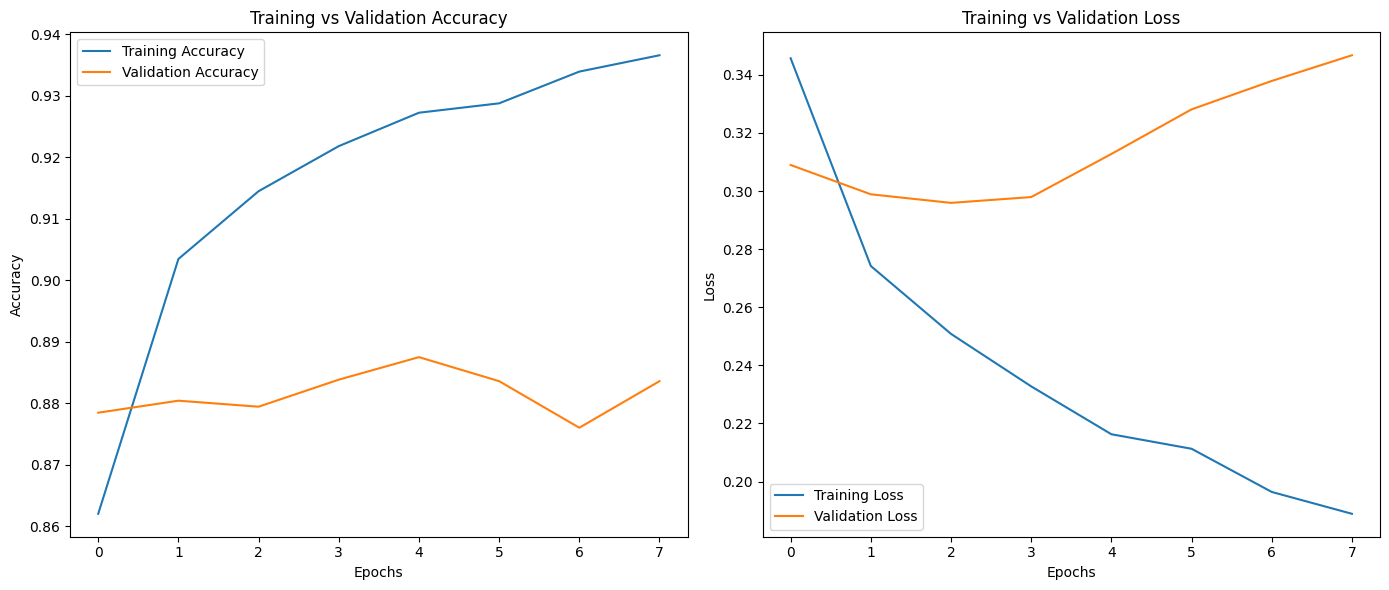

In [46]:
plot_hist(history)

## Tests

In [47]:
def evaluate_model(y_true, y_pred):
    """
    Exibe métricas de classificação e matriz de confusão para as predições do modelo.

    Args:
    ----------
    y_true: Ground truth (valores reais) [type: array]
    y_pred: Predições feitas pelo modelo [type: array]
    """
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def display_predictions(df, y_true, y_pred, n=5):
    """
    Exibe exemplos de predições corretas e incorretas do modelo.

    Args:
    ----------
    df: DataFrame original com os comentários [type: pandas.DataFrame]
    y_true: Ground truth (valores reais) [type: array]
    y_pred: Predições feitas pelo modelo [type: array]
    n: Número de exemplos para exibir [type: int, default: 5]
    """
    df['true_label'] = y_true
    df['predicted_label'] = y_pred
    correct = df[df['true_label'] == df['predicted_label']].sample(n)
    incorrect = df[df['true_label'] != df['predicted_label']].sample(n)

    print("Correct Predictions:")
    print(correct[['comment', 'true_label', 'predicted_label']])
    print("\nIncorrect Predictions:")
    print(incorrect[['comment', 'true_label', 'predicted_label']])



129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81      1398
           1       0.89      0.94      0.91      2700

    accuracy                           0.88      4098
   macro avg       0.88      0.85      0.86      4098
weighted avg       0.88      0.88      0.88      4098

Accuracy: 0.88


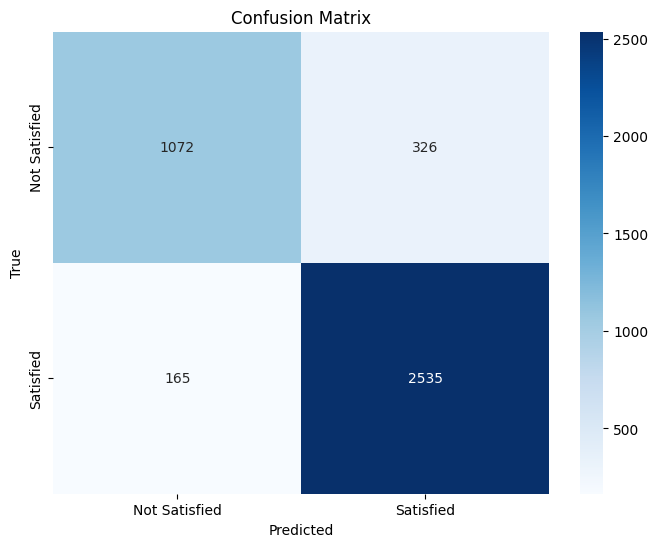

In [48]:
X_array=np.array(X)

y_pred = best_lstm_model.predict(X_test)
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Visualize examples
def get_correct_and_incorrect(X_test: np.array, y_test: pd.Series, y_pred: np.array, n=10):
    df_test = pd.DataFrame(X_test).iloc[y_test.index]
    df_test['true_label'] = y_test.values
    df_test['predicted_label'] = y_pred
    df_test.columns = ['comment' if i == 0 else col for i, col in enumerate(df_test.columns)]

    correct = df_test[df_test['true_label'] == df_test['predicted_label']].sample(n)
    incorrect = df_test[df_test['true_label'] != df_test['predicted_label']].sample(n)

    return correct, incorrect

correct, incorrect = get_correct_and_incorrect(X_array, y_test, y_pred_binary)

evaluate_model(y_test, y_pred_binary)


In [49]:
print("Correct examples:")
correct

Correct examples:


,comment,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,true_label,predicted_label
12283,3,72,6,21,73,777,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4500,8,1,21,37,621,232,149,135,69,8,...,0,0,0,0,0,0,0,0,0,0
9391,1,3,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
37695,7673,257,7674,2221,512,7675,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
14518,159,3,362,18,347,23,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
20230,171,1411,355,3,1083,8,1,132,340,1,...,0,0,0,0,0,0,0,0,0,0
16739,250,266,41,3,110,36,2,5738,37,3,...,0,0,0,0,0,0,0,0,0,0
6404,8,25,41,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8879,7,104,23,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
19824,1,13,29,3,28,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [50]:
print("Incorrect examples:")
incorrect


Incorrect examples:


,comment,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,true_label,predicted_label
32534,222,81,2,3,397,293,708,36,485,1059,...,0,0,0,0,0,0,0,0,0,1
4380,856,105,36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
538,50,95,89,78,148,2,3,4,89,95,...,0,0,0,0,0,0,0,0,1,0
35470,143,42,44,2,12,1046,28,1041,0,0,...,0,0,0,0,0,0,0,0,0,1
32228,19,2,177,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6324,69,376,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18097,36,2,3,235,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36707,22,1867,7,2590,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1549,17,11,432,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
40512,3952,328,164,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
def display_top_features(vectorizer, model, n=10):
    """
    Mostra as palavras mais relevantes usadas pelo modelo.

    Args:
    ----------
    vectorizer: Vetorizador usado para o pré-processamento [type: TfidfVectorizer ou CountVectorizer]
    model: Modelo treinado [type: sklearn.linear_model ou similar]
    n: Número de palavras para exibir [type: int, default: 10]
    """
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_[0]
    top_positive = sorted(zip(coef, feature_names), reverse=True)[:n]
    top_negative = sorted(zip(coef, feature_names))[:n]

    print("Top Positive Features:")
    for c, f in top_positive:
        print(f"{f}: {c:.4f}")

    print("\nTop Negative Features:")
    for c, f in top_negative:
        print(f"{f}: {c:.4f}")


## Dense model with Regex Transformers + TF-IDF Vectorizer

### Feature Extraction

After the RegEx, stopwords removal and stemming application, we can use Bag of Words, TF-IDF and Word2Vec to get more meaning. To make our analysis easier, let's define a function that receives a text and a vectorizer object and applies the feature extraction on the respective text.

#### CountVectorizer

Count vectorization is a technique in NLP that converts text documents into a matrix of token counts. Tokens can be words, characters, or n-grams. Each token represents a column in the matrix, and the resulting vector for each document has counts for each token.

On the Bag of Words approach, we create a dictionary vocabulary with all the unique words and, for each word in each comment/text string, we index the words into a vector that represents the occurrence (1) or not (0) of each word. This is a way for transforming a text into a frequency vector considering a literal bag of words (dictionary vocabulary).

Example:

In [52]:
corpus = [
    'This is the first document',
    'This document is the second document',
    'and this is the third one',
    'is this the first document'
]

vec = CountVectorizer().fit(corpus)
vec.vocabulary_

{'this': 8,
 'is': 3,
 'the': 6,
 'first': 2,
 'document': 1,
 'second': 5,
 'and': 0,
 'third': 7,
 'one': 4}

In [53]:
vec.transform(corpus).toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

#### TF-IDF

With the Bag of Words approach, each word has the same weight, which may not be true all the time, especially for those words with a very low frequency in the corpus. So, the TF-IDF (Term Frequency and Inverse Document Frequency) approach can be used with the scikit-learn library following the formulas:

$$
TF = \frac{\text{Frequency of a word in the document}}{\text{Total words in the document}}
$$

$$
IDF = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents containing the word}}\right)
$$

The purpose of using tf-idf instead of simply counting the frequency of a token in a document is to reduce the influence of tokens that appear very frequently in a given collection of documents. These tokens are less informative than those appearing in only a small fraction of the corpus. Scaling down the impact of these frequently occurring tokens helps improve text-based machine-learning models’ accuracy.

Example:

In [54]:
vectorized = vec.transform(corpus).toarray()
tfid = TfidfTransformer().fit(vectorized)

tfid.transform(vectorized).toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

In [55]:
# [TEXT PREP] Classe para aplicar uma série de funções RegEx definidas em um dicionário
class ApplyRegex(BaseEstimator, TransformerMixin):

    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)

        return X


# [TEXT PREP] Classe para aplicar a remoção de stopwords em um corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):

    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]


# [TEXT PREP] Classe para aplicar o processo de stemming em um corpus
class StemmingProcess(BaseEstimator, TransformerMixin):

    def __init__(self, stemmer):
        self.stemmer = stemmer

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]


# [TEXT PREP] Classe para extração de features de um corpus (vocabulário / bag of words / TF-IDF)
class TextFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self, vectorizer, train=True):
        self.vectorizer = vectorizer
        self.train = train

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.train:
            return self.vectorizer.fit_transform(X).toarray()
        else:
            return self.vectorizer.transform(X)

In [56]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(nltk.corpus.stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(nltk.stem.RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

* max_features=300: indicates that the matrix will be created using the 300 most common words from the corpus
* max_df=0.8: indicates that we will use only words with at least 80% frequency in the corpus
* min_df=7: indicates that we will use only words that occurs in at least 7 text strings in the corpus

In [57]:
X = df_comments['comment']

X_transformed = text_pipeline.fit_transform(reviews_final)

In [58]:
X_train_trans, X_val_trans, X_test_trans, y_train_trans, y_val_trans, y_test_trans = train_val_test_split(X_transformed, y)

In [59]:
X_train_trans[500]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.43824671,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.32527411, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Models

We will train a bunch of models to see if we can improve performance in relation to the lstm model without TF-IDF

Epoch 1/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.8217 - loss: 0.3840 - val_accuracy: 0.8853 - val_loss: 0.2954
Epoch 2/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.8935 - loss: 0.2826 - val_accuracy: 0.8870 - val_loss: 0.2910
Epoch 3/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.8974 - loss: 0.2725 - val_accuracy: 0.8878 - val_loss: 0.2891
Epoch 4/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.9023 - loss: 0.2584 - val_accuracy: 0.8895 - val_loss: 0.2885
Epoch 5/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.9085 - loss: 0.2506 - val_accuracy: 0.8880 - val_loss: 0.2923
Epoch 6/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - accuracy: 0.9161 - loss: 0.2367 - val_accuracy: 0.8860 - val_loss: 0.2979
Epoch 7/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9209 - loss: 0.2230 - val_accuracy: 0.8863 - val_loss: 0.3060
Epoch 8/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 

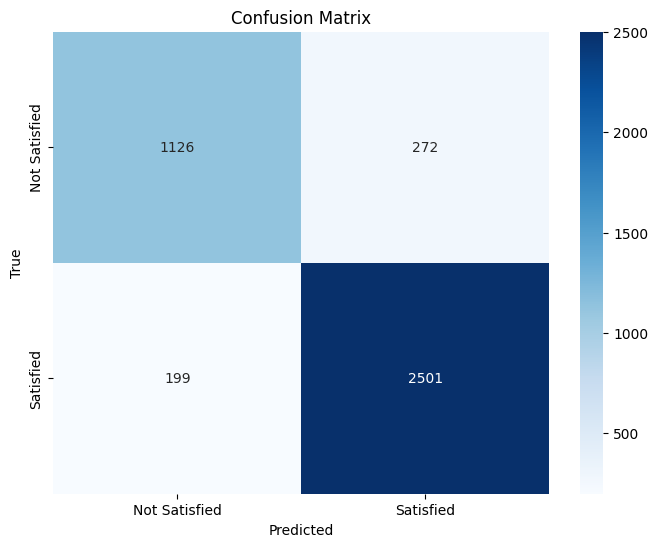

In [60]:
model = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_trans, y_train_trans, epochs=100, batch_size=32, validation_data=(X_val_trans, y_val_trans), callbacks=early_stopping)

# Model evaluation
y_pred = model.predict(X_test_trans)
y_pred_binary = np.where(y_pred[:,1] >= 0.5, 1, 0)

correct, incorrect = get_correct_and_incorrect(X_array, y_test_trans, y_pred_binary)

evaluate_model(y_test_trans, y_pred_binary)

In [61]:
print("Correct examples:")
correct

Correct examples:


,comment,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,true_label,predicted_label
11450,3,192,616,6,413,189,6,682,95,723,...,0,0,0,0,0,0,0,0,0,0
40900,2,8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5705,23,3,4,15,202,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
35807,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
23712,53,1,2,3,19,27,8,1,105,39,...,0,0,0,0,0,0,0,0,0,0
4322,15,3,1,9,4,133,107,33,1,0,...,0,0,0,0,0,0,0,0,1,1
27625,1,7,9,37,150,13,29,26,0,0,...,0,0,0,0,0,0,0,0,1,1
23566,127,38,434,6364,188,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
11715,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
23268,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [62]:
print("Incorrect examples:")
incorrect

Incorrect examples:


,comment,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,true_label,predicted_label
34434,289,7383,1,2,233,25,12,0,0,0,...,0,0,0,0,0,0,0,0,1,0
791,100,1,10,44,2,246,26,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35123,3,105,59,21,75,1078,1826,236,993,21,...,0,0,0,0,0,0,0,0,1,0
22682,12,155,41,930,112,744,66,1185,0,0,...,0,0,0,0,0,0,0,0,1,0
40374,1,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19407,89,569,368,85,30,167,54,425,0,0,...,0,0,0,0,0,0,0,0,0,1
31952,2,255,19,934,190,188,41,355,39,174,...,0,0,0,0,0,0,0,0,0,1
5010,182,344,207,432,44,19,40,120,1253,41,...,0,0,0,0,0,0,0,0,1,0
20935,24,807,240,2270,4,6,21,27,0,0,...,0,0,0,0,0,0,0,0,0,1
30237,220,38,197,66,152,41,134,78,220,1656,...,0,0,0,0,0,0,0,0,1,0


Epoch 1/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - accuracy: 0.8300 - loss: 0.3771 - val_accuracy: 0.8860 - val_loss: 0.2937
Epoch 2/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.8919 - loss: 0.2824 - val_accuracy: 0.8880 - val_loss: 0.2898
Epoch 3/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.8993 - loss: 0.2673 - val_accuracy: 0.8892 - val_loss: 0.2882
Epoch 4/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.9037 - loss: 0.2556 - val_accuracy: 0.8880 - val_loss: 0.2889
Epoch 5/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.9098 - loss: 0.2424 - val_accuracy: 0.8831 - val_loss: 0.2976
Epoch 6/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9161 - loss: 0.2305 - val_accuracy: 0.8856 - val_loss: 0.3035
Epoch 7/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.9207 - loss: 0.2188 - val_accuracy: 0.8858 - val_loss: 0.3113
Epoch 8/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 

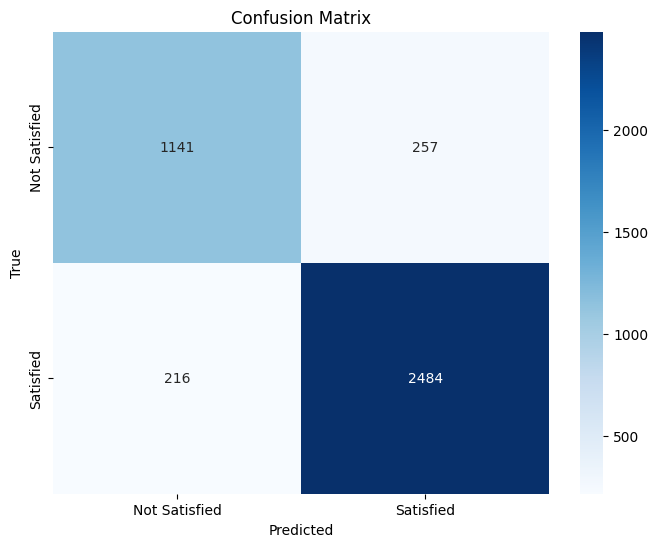

In [63]:
model = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_trans, y_train_trans, epochs=100, batch_size=32, validation_data=(X_val_trans, y_val_trans), callbacks=early_stopping)

# Model evaluation
y_pred = model.predict(X_test_trans)
y_pred_binary = np.where(y_pred[:,1] >= 0.5, 1, 0)

correct, incorrect = get_correct_and_incorrect(X_array, y_test_trans, y_pred_binary)

evaluate_model(y_test_trans, y_pred_binary)


Epoch 1/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8297 - loss: 0.3839 - val_accuracy: 0.8875 - val_loss: 0.2943
Epoch 2/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8942 - loss: 0.2843 - val_accuracy: 0.8873 - val_loss: 0.2924
Epoch 3/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9022 - loss: 0.2673 - val_accuracy: 0.8882 - val_loss: 0.2922
Epoch 4/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9073 - loss: 0.2539 - val_accuracy: 0.8865 - val_loss: 0.2907
Epoch 5/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9151 - loss: 0.2356 - val_accuracy: 0.8851 - val_loss: 0.2978
Epoch 6/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9229 - loss: 0.2174 - val_accuracy: 0.8846 - val_loss: 0.3066
Epoch 7/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9292 - loss: 0.2018 - val_accuracy: 0.8814 - val_loss: 0.3285
Epoch 8/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9346 - loss: 0

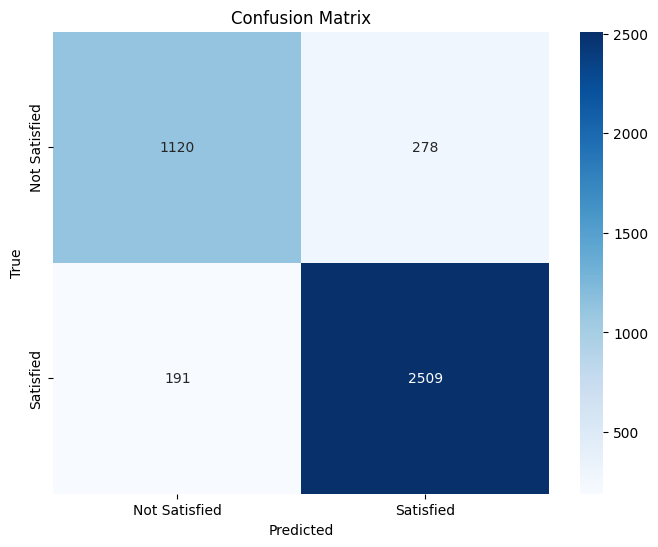

In [64]:
model = models.Sequential([
    layers.Dense(254, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_trans, y_train_trans, epochs=100, batch_size=32, validation_data=(X_val_trans, y_val_trans), callbacks=early_stopping)

# Model evaluation
y_pred = model.predict(X_test_trans)
y_pred_binary = np.where(y_pred[:,1] >= 0.5, 1, 0)

correct, incorrect = get_correct_and_incorrect(X_array, y_test_trans, y_pred_binary)

evaluate_model(y_test_trans, y_pred_binary)

Epoch 1/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8371 - loss: 0.3720 - val_accuracy: 0.8865 - val_loss: 0.2956
Epoch 2/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8961 - loss: 0.2841 - val_accuracy: 0.8878 - val_loss: 0.2900
Epoch 3/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9033 - loss: 0.2644 - val_accuracy: 0.8882 - val_loss: 0.2918
Epoch 4/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9131 - loss: 0.2431 - val_accuracy: 0.8860 - val_loss: 0.2955
Epoch 5/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9192 - loss: 0.2241 - val_accuracy: 0.8826 - val_loss: 0.3224
Epoch 6/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9273 - loss: 0.2020 - val_accuracy: 0.8831 - val_loss: 0.3359
Epoch 7/100
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9365 - loss: 0.1828 - val_accuracy: 0.8785 - val_loss: 0.4063
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
Classification Report:
              pre

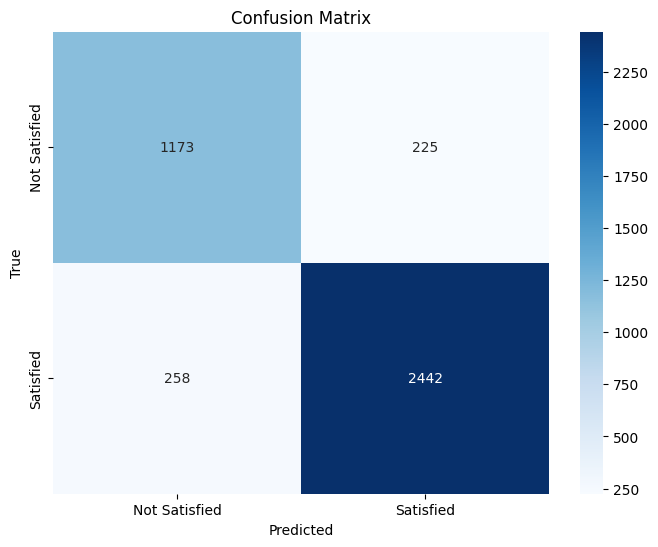

In [65]:
model = models.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(254, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_trans, y_train_trans, epochs=100, batch_size=32, validation_data=(X_val_trans, y_val_trans), callbacks=early_stopping)

# Model evaluation
y_pred = model.predict(X_test_trans)
y_pred_binary = np.where(y_pred[:,1] >= 0.5, 1, 0)

correct, incorrect = get_correct_and_incorrect(X_array, y_test_trans, y_pred_binary)

evaluate_model(y_test_trans, y_pred_binary)

## Teste with sentences

In [66]:
def test_new_sentence_lstm(new_sentence, model, tokenizer=tokenizer, max_sequence_length=max_length):
    regex_transformers = {
        'break_line': re_breakline,
        'hiperlinks': re_hiperlinks,
        'dates': re_dates,
        'money': re_money,
        'numbers': re_numbers,
        'negation': re_negation,
        'special_chars': re_special_chars,
        'whitespaces': re_whitespaces
        # 'stemming': stemming_process
    }
    
    
    # Pre-process
    regex = ApplyRegex(regex_transformers)
    sentence_processed = regex.transform([new_sentence])
    sentence_processed = [' '.join(stopwords_removal(review)) for review in sentence_processed]
    sentence_processed = [' '.join(stemming_process(review)) for review in sentence_processed]
    
    print(sentence_processed)

    # Tokenizer and padding e aplicando padding
    tokenized_sentence = tokenizer.texts_to_sequences(sentence_processed)
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_sequence_length, padding="post")
    print(padded_sentence)
    
    # Result
    prediction = model.predict(padded_sentence)
    print(prediction)

    review = "positive" if prediction >= 0.5 else "negative"
    print(f"The sentence represents a {review} review!")

In [67]:
new_sentence = 'Comprei um gift card e ainda estou esperando chegar, é um produto digital, todos os sites mandam no mesmo instante, \
e o vulgo "maior da América Latina" simplesmente não consegue entregar um simples código no e-mail. Não recomendo, serviço péssimo.'
test_new_sentence_lstm(new_sentence, best_lstm_model)

['compr gift card aind esper cheg produt digit tod sit mand instant vulg mai amér latin simples neg conseg entreg simpl códig mail neg recom serviç péss']
[[   5 3568   19   27    7    1  943   38   35  114 3512  204 1199  411
     2  832    3  322  487  232    2   11  182  126    0    0    0    0
     0    0    0    0    0    0    0    0    0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.0680415]]
The sentence represents a negative review!


In [68]:
new_sentence='Sou estudante da instituição e fui selecionada para receber o benefício PAES no semestre 2024.1, \
recebi o pagamento do benefício do mês passado com atraso e este mês ainda não recebi. Colegas que também foram selecionados pelo benefício,\
falaram que já receberam 1.200 ao todo, pois no mês passado receberam 800 e este mês, 400. Mandei e-mails em busca de uma ajuda e me \
responderam para esperar os 10 dias uteis, liguei e me mandaram retornar na segunda-feira, 18 de novembro (hoje) e ao ligar, descobri que a \
folha de pagamento fechou e só receberei o meu pagamento em janeiro. Ao solicitar esse benefício, expliquei que estava solicitando pois através \
dele, eu manteria as minhas despesas como estudante (almoço e transporte) e sem este benefício, eu não conseguiria continuar estudando na universidade.\
Agora terei que esperar até janeiro por conta de um erro da instituição, podendo correr o risco de não conseguir assistir as aulas por conta da falta de transporte.'
test_new_sentence_lstm(new_sentence, best_lstm_model)

['estud institu selecion receb benefíci pae semestr numer numer receb pag benefíci mê pass atras mê aind neg receb coleg selecion benefíci fal receb numer numer tod poi mê pass receb numer mê numer mand mail busc ajud respond esper numer dia utel lig mand retorn segund feir numer novembr hoj lig descobr folh pag fech receb pag jan solic benefíci expliq solicit poi através mant desp estud almoç transport benefíci neg consegu continu estud univers agor esper jan cont err institu pod corr risc neg consegu assist aul cont falt transport']
[[ 489    8   53  964  871  377 4841   95   39  721  571 3132 1765 3504
   240  377    2  252  231 1765 1422   52   27  964  216   79 4086   72
   431  427    2  252 1134 6632  216   45  240]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.25387293]]
The sentence represents a negative review!


In [69]:
new_sentence='O SITE POSTOU UM COMUNICADO COM A PRIMEIRA RESPOSTA DA VERIFICAÇÃO DOS DOCUMENTOS E MANDOU UM EDITAL DIZENDO QUE EU PODERIA REENVIAR OS DOCUMENTOS CASO NÃO TIVESSE COMPATÍVEL COM A INSCRIÇÃO. PORÉM, NO SITE DE CONSULTA, NÃO ME DÃO A OPÇÃO DE REENVIAR, MAS SOMENTE A DE CONSULTAR O DOCUMENTOS QUE JÁ ENVIEI ANTERIORMENTE.'
test_new_sentence_lstm(new_sentence, best_lstm_model)

['sit post comunic prim respost verific document mand edit diz pod reenvi document cas neg compat inscr porém sit consult neg dão opç reenvi soment consult document envi anteri']
[[  35  348  428  130  120  464 1249  114  145   72  948 1249  109    2
   598   44   35 1289    2  834  546  948  122 1289 1249   56  642    0
     0    0    0    0    0    0    0    0    0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.32852888]]
The sentence represents a negative review!


In [70]:
new_sentence='Excelente produto pessoal, parabens, legal, gostei, voltarei!'
test_new_sentence_lstm(new_sentence, best_lstm_model)

['excel produt pessoal parab legal gost volt']
[[ 23   1 688 298 430  17 123   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.97770864]]
The sentence represents a positive review!


In [71]:
new_sentence='Não tenho palavras para descrever o quão especial você é para mim. Sei que sua caixa de mensagens deve estar cheia, pois você é uma pessoa muito querida por todos. Mas gostaria de te relembrar todo o carinho que sinto por você e quão grato eu sou por te ter na minha vida.\
Hoje, quero lhe desejar o mais feliz dos aniversários. Que esse dia seja de muita celebração, abraços apertados e sorrisos sinceros ao lado das pessoas que você mais ama. Espero poder celebrar muitos outros anos contigo.\
Parabéns pelo seu dia.'
test_new_sentence_lstm(new_sentence, best_lstm_model)

['neg palavr descrev quã espec mim sei caix mens dev chei poi pesso quer tod gost relembr tod car sint quã grat ter vid hoj quer desej feliz aniversári dia muit celebr abraç apert sorris sincer lad pesso ama esper pod celebr muit outr ano contig parabém dia']
[[ 191  101  410   75  814   39  358   61   38   17   38  198  885  417
    69 1107  134   61  230  288  933   21  179  927  930 6649 2251  671
   358 3362   27   72  179   32  308   48   21]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.60549736]]
The sentence represents a positive review!


## Multiclassification problem

In [72]:
from tensorflow.keras.utils import to_categorical


In [73]:
num_classes = df_comments['score'].nunique()
y_one_hot = to_categorical(df_comments['score'] - 1, num_classes=num_classes)
y_one_hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [74]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(reviews_padded, y_one_hot)

In [75]:
def create_lstm_model_multiclass(num_layers, units_per_layer, input_shape, num_classes):
    model = models.Sequential()
    
    # Embedding layer
    model.add(layers.Embedding(input_dim=input_shape[0], output_dim=50))
    
    # LSTM layers
    for i in range(num_layers):
        return_sequences = i < num_layers - 1  # Last layer doesn't return sequence
        model.add(layers.LSTM(units_per_layer, return_sequences=return_sequences))
        model.add(layers.Dropout(0.2))
    
    # Output layer for multiclass classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile with categorical loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

lstm_multiclass_model = create_lstm_model_multiclass(
    num_layers=best_config['num_layers'],
    units_per_layer=best_config['units_per_layer'],
    input_shape=X_train.shape,
    num_classes=num_classes
)

In [76]:
# lstm_model = models.Sequential()
# lstm_model.add(layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_length))
# lstm_model.add(layers.LSTM(units=128, return_sequences=True))
# lstm_model.add(layers.Dropout(0.2))
# lstm_model.add(layers.LSTM(units=128))
# lstm_model.add(layers.Dropout(0.2))
# lstm_model.add(layers.Dense(units=1, activation='sigmoid'))

# lstm_model.summary()

In [77]:
lstm_multiclass_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = lstm_multiclass_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5861 - loss: 1.1519 - val_accuracy: 0.6662 - val_loss: 0.9316
Epoch 2/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6854 - loss: 0.8935 - val_accuracy: 0.6672 - val_loss: 0.9045
Epoch 3/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6911 - loss: 0.8569 - val_accuracy: 0.6774 - val_loss: 0.8843
Epoch 4/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7000 - loss: 0.8223 - val_accuracy: 0.6811 - val_loss: 0.8869
Epoch 5/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7114 - loss: 0.7974 - val_accuracy: 0.6781 - val_loss: 0.8953
Epoch 6/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7220 - loss: 0.7754 - val_accuracy: 0.6784 - val_loss: 0.9043
Epoch 7/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7281 - loss: 0.7599 - val_accuracy: 0.6698 - val_loss: 0.9190
Epoch 8/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7374 - loss: 0.7406 -

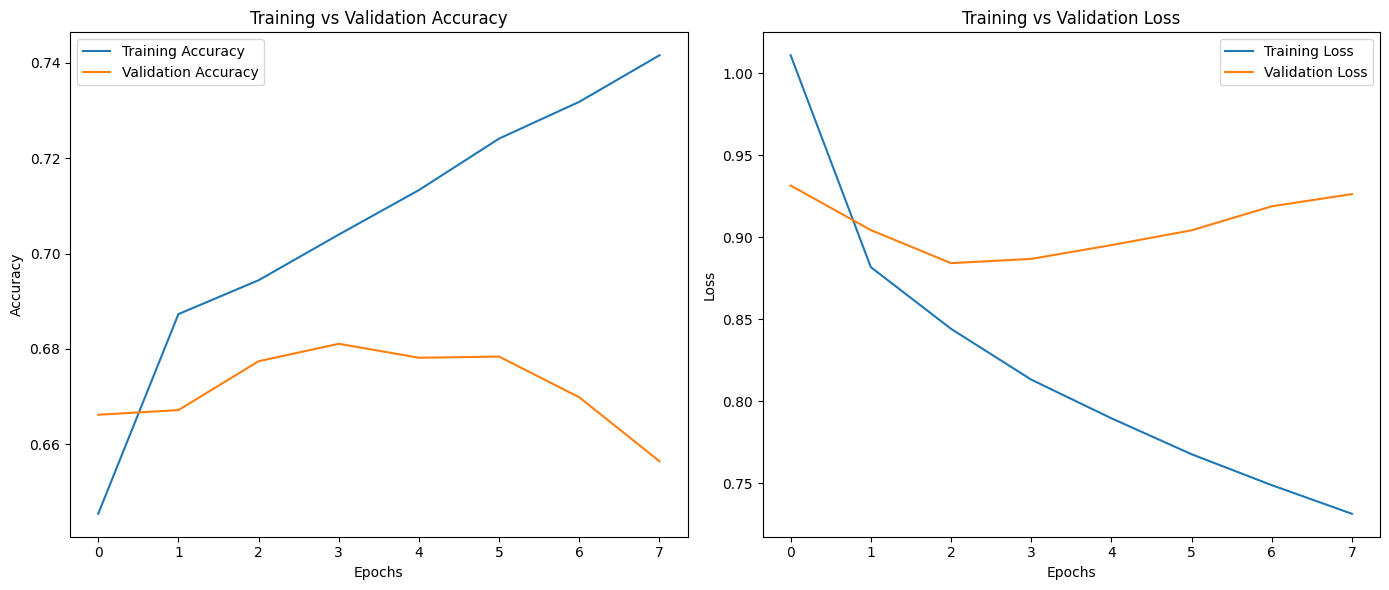

In [79]:
plot_hist(history)

In [80]:
# Model evaluation
y_pred_probs = lstm_multiclass_model.predict(X_test)  # probability

# Converts from one-hot back to original classes
y_pred = y_pred_probs.argmax(axis=-1) + 1
y_true = y_test.argmax(axis=-1) + 1


print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(1, num_classes + 1)]))

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

     Class 1       0.64      0.88      0.74       834
     Class 2       0.00      0.00      0.00       202
     Class 3       0.28      0.09      0.14       362
     Class 4       0.27      0.08      0.12       649
     Class 5       0.74      0.95      0.83      2051

    accuracy                           0.68      4098
   macro avg       0.39      0.40      0.37      4098
weighted avg       0.57      0.68      0.60      4098



d:\Code\Data Science\Projects\brazilian-e-commerce-nlp-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Data Science\Projects\brazilian-e-commerce-nlp-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Code\Data Science\Projects\brazilian-e-commerce-nlp-deep-learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

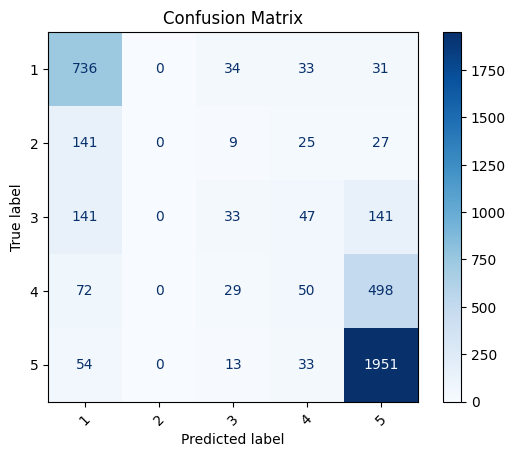

In [81]:
cm = confusion_matrix(y_true, y_pred, labels=range(1, num_classes + 1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, num_classes + 1))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


As expected, the multiple classification problem is more difficult for the model, but it still performed well considering that scores like 3 to 2 can be arbitrary.